In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
#assume that vectors of interest are along the last dimension

def softmax(s):
    amax = np.amax(s, axis=0, keepdims=True)
    return amax + np.log(np.sum(np.exp(s - amax), axis=0))

def softargmax(s):
    return np.exp(s - softmax(s))

def hessian(s):
    # only works for 1d input
    p = softargmax(s)
    return np.diag(p) - np.outer(p, p)

def var(p,x):
    average = np.sum(p*x)
    return np.sum(p* x**2) - average**2

def varoperator(p):
    return np.diag(p) - np.outer(p, p)


In [22]:
s = np.random.randn(3)
a = softmax(s)
p = softargmax(s)
H = hessian(s)
print(s)
print(a)
print(p, p.sum())
print(H)
print(np.linalg.det(H[:-1,:-1]))

[ 1.69913704 -0.65562969  0.34953421]
[ 2.0023914]
[ 0.73841125  0.07008678  0.19150197] 1.0
[[ 0.19316008 -0.05175287 -0.14140721]
 [-0.05175287  0.06517462 -0.01342176]
 [-0.14140721 -0.01342176  0.15482897]]
0.00991077597524


In [23]:
spectrum, eigvectors = np.linalg.eigh(H)
print(spectrum)
print("condition number ",spectrum[-1]/spectrum[1])
print(eigvectors)

onevec = eigvectors[:,1]
print(np.dot(np.dot(H, onevec), onevec))
print(var(p, onevec))

[  2.19957516e-17   9.28113375e-02   3.20352327e-01]
condition number  3.45165079815
[[ 0.57735027  0.29948282 -0.75958983]
 [ 0.57735027 -0.8075655   0.12043518]
 [ 0.57735027  0.50808268  0.63915464]]
0.0928113374545
0.0928113374545


In [28]:
from simplex import Simplex

In [29]:
simplex = Simplex()

Simplex with resolution 6: 2145 points.


In [30]:
# study the evolution of the condition number in 3-simplex
def smoothness(probas):
    ans = []
    for proba in probas:
        score = np.log(proba + 1e-12)
        eigenvalues, eigenvectors = np.linalg.eigh(hessian(score))
        ans.append(eigenvalues[-1])

    return np.array(ans)

def volume(probas):
    ans = []
    for proba in probas:
        ans.append(np.linalg.det(varoperator(proba)[:-1,:-1]))

    return np.array(ans)

def log_condition_number(probas, cap=2):
    return np.minimum(np.log10(condition_number(probas)), cap)

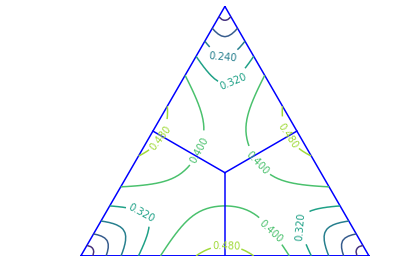

In [31]:
simplex.show_func(smoothness)

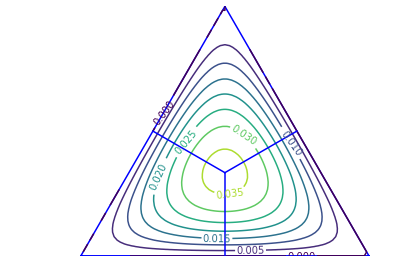

In [32]:
simplex.show_func(volume)

smooth but strongly convex only in a subspace

What are tajectories of gradient descent ? They are straight line in the score space, but what do they look like in the probability space?

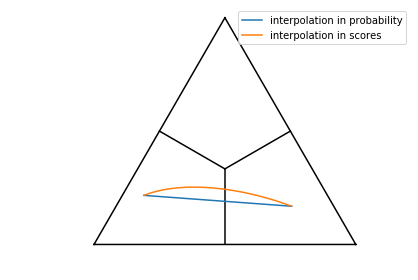

In [135]:
# interpolation line

p1 = 0
p2 = 0
while np.sum((p1-p2)**2) < .3:
    s1 = np.random.randn(3)
    p1 = softargmax(s1)

    s2 = np.random.randn(3)
    p2 = softargmax(s2)
    

interp = np.linspace(0,1,100)[:,np.newaxis]
proba_line = interp*p1 + (1-interp)*p2
score_line = softargmax((interp*s1 + (1-interp)*s2).T).T

# plot
simplex.show_borders(color='black')

cartprobas = simplex.bary2cart(proba_line).T
plt.plot(cartprobas[0], cartprobas[1], label='interpolation in probability')

cartscores = simplex.bary2cart(score_line).T
plt.plot(cartscores[0], cartscores[1], label='interpolation in scores')
plt.legend()
pass

# third order derivative of softmax

The third order gradient $\nabla^3 f(s)$ evaluated at $s$ and applied to $v\otimes v\otimes v$ is equal to the third order cumulant or third order centered moment of $v_i, i\sim p(s) = \nabla f(s)$.

$$\nabla^3 f(s)(v^{\otimes 3}) = E_{i\sim p(s)}\left[(v_i - E[v_j])^3 \right]$$

For a Bernoulliof parameter $p$ ($K=2$) and support $v_+>v_-$ instead of $0,1$, this is written as 

$$p(1-p)(2p-1)(v_+ - v_-)^3$$

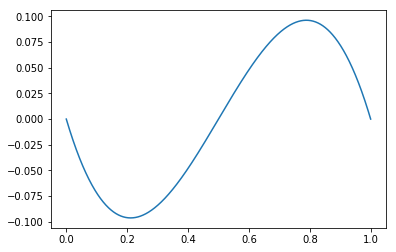

In [141]:
pp = np.linspace(0,1,1000)
skewness = pp*(1-pp)*(2*pp-1)
plt.plot(pp, skewness)

In [150]:
imax = np.argmax(skewness)
print('The max value of third order moment of Bernoulli is {:.2f}={:.2f} reached for p={:.2f}={:.2f}.'
      .format(skewness[imax], .5*3**(-1.5), pp[imax], .5*(1+1/np.sqrt(3))))
print(f'If we add the unit constraint on the support then it is {.5*(2/3)**1.5:.2f}')

The max value of third order moment of Bernoulli is 0.10=0.10 reached for p=0.79=0.79.
If we add the unit constraint on the support then it is 0.27


I make the conjecture that the Hessian of the softmax is 1/3 Lipschitz

# Study the Wishart distribution
The eigenvalues of samples from the inverse wishart can get arbitrarily large when the degree of freedom is equal to the dimension of the scale matrix. This is mitigated by increasing the degree of freedom.

In [28]:
import scipy

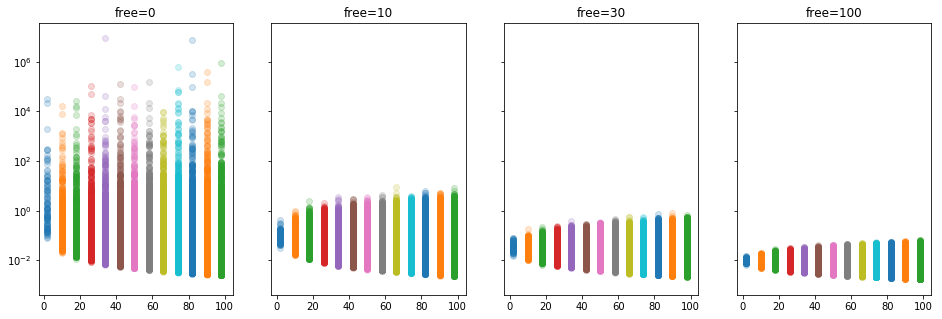

In [164]:
freedoms = [0,10,30,100]
dims = np.arange(2,100,8)
fig, axs = plt.subplots(ncols=len(freedoms), figsize=(16,5), sharey=True)
for k, ax in zip(freedoms, axs):
    ax.set_title(f'free={k}')
    ax.set_yscale('log')
    ax.autoscale()
    for dim in range(2,100,8):
        invwish = scipy.stats.invwishart(df=dim+k,scale=np.eye(dim))
        sam = invwish.rvs(50)
        val, _ = np.linalg.eigh(sam)
        val = val.flatten()
        ax.scatter(dim*np.ones_like(val), val, alpha=.2)

# Expected distance for categorical distributions


In [74]:
import categorical_distance
dcateg = categorical_distance.experiment(50,1000,1,'independent')

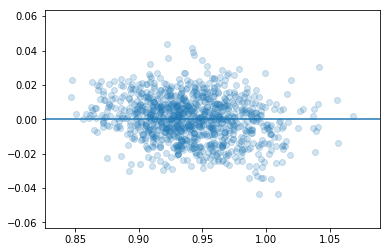

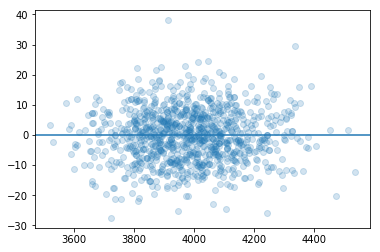

In [75]:
plt.scatter(dcateg[0,0],dcateg[1,0]- dcateg[0,0], alpha=0.2)
plt.plot([0,1e20],[0,0], scalex=False,scaley=False)
plt.figure()
plt.scatter(dcateg[0,1],dcateg[1,1] - dcateg[0,1], alpha=0.2)
plt.plot([0,1e20],[0,0], scalex=False,scaley=False)


In [86]:
jointcateg = categorical_distance.sample_joint(3,100,1,False)
revcateg = jointcateg.reverse()
sy = revcateg.sa
sxy = revcateg.sba
sx = jointcateg.sa
syx = jointcateg.sba
my = np.mean(syx, axis=1)
#print(sy - my)
print(np.allclose(np.sum(sy,axis=1), 0 ))
print(np.allclose(np.sum(my,axis=1), 0 ))

dify = syx - sy[:,None,:]
difx = sxy - sx[:,None,:]
print(np.sum((dify - difx)**2))

True
True
1174.03373343


In [65]:
def plot6categ(quart1,median,quart3,intervention):

    def plotfill(ax,index,label):
        ax.plot(kk,median[:,index], label=label)
        ax.fill_between(kk, quart1[:,index], quart3[:,index], alpha=0.3)
        ax.set_title(label)
        ax.grid()

    fig, axs = plt.subplots(2,3, figsize=(16,10))
    plotfill(axs[0,0], 0, 'proba causal')
    plotfill(axs[0, 1], 1, 'proba anticausal')
    plotfill(axs[0, 1], 6, 'proba anticausal')
    plotfill(axs[0,2], 2, 'ratio anticausal/causal')

    slope = np.median(median[:,3]/kk)
    axs[1, 0].plot(kk,kk*slope, label='line fit',color='orange')
    plotfill(axs[1, 0], 3, f'scores causal - slope={slope:.2f}')

    sqcoeff = np.median(median[:,4]/kk**2)
    axs[1,1].plot(kk,kk**2 * sqcoeff, label='quadratic fit', color='orange')
    plotfill(axs[1, 1], 4, f'scores anticausal - coeff={sqcoeff:.2f}')
    plotfill(axs[1, 1], 7, f'scores anticausal - coeff={sqcoeff:.2f}')

    plotfill(axs[1,2], 5, 'ratio anticausal/causal')

    plt.savefig(f'categorical_distances_{intervention}.pdf')
    
    return fig, axs

In [430]:
def categoricaldist(k,n):
    return categorical_distances_cause(k,n,concentration=.5)


dist = compute_distances(categoricaldist)
median,quart1,quart3 = compute_percentile(dist)

In [431]:
bscoresdistance = dist[:,:,7]
print(bscoresdistance.mean())
print(bscoresdistance.std())

3.16649209137
1.42986942106


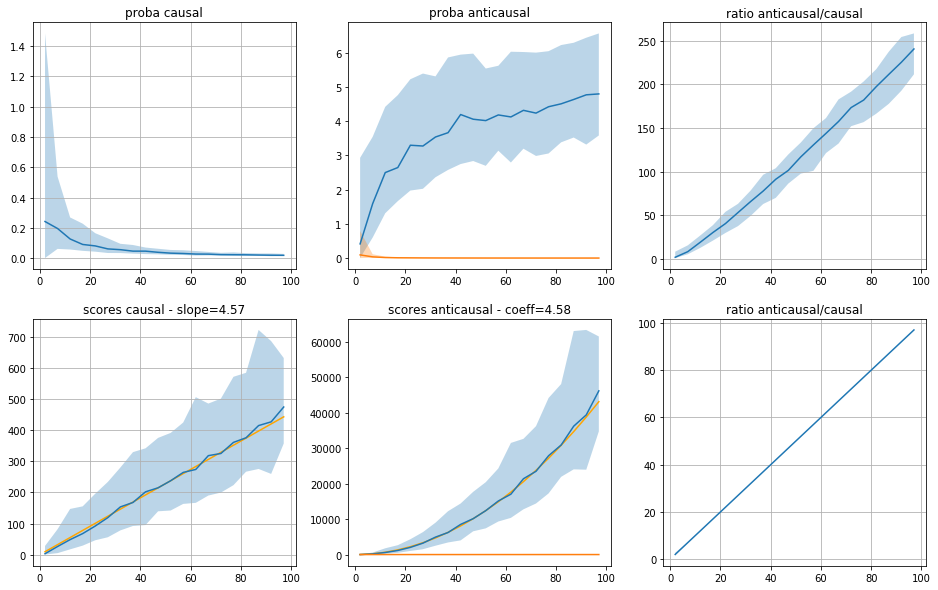

In [432]:
plot6categ(quart1, median, quart3, 'cause')

In [448]:
def categeffect(k,n):
    return categorical_distances_effect(k, n, concentration=.1)

dist = compute_distances(categeffect)
median,quart1,quart3 = compute_percentile(dist)

In [449]:
median[:,7]*kk

array([  6.04225882e+01,   2.61257924e+03,   1.03712291e+04,
         2.09610011e+04,   4.17309815e+04,   6.47103807e+04,
         8.95936239e+04,   1.23102561e+05,   1.66604904e+05,
         1.95734933e+05,   2.49265253e+05,   2.99003514e+05,
         3.61370276e+05,   4.37894312e+05,   4.89908833e+05,
         5.60148695e+05,   6.52446627e+05,   7.62586358e+05,
         8.59052007e+05,   8.96890349e+05])

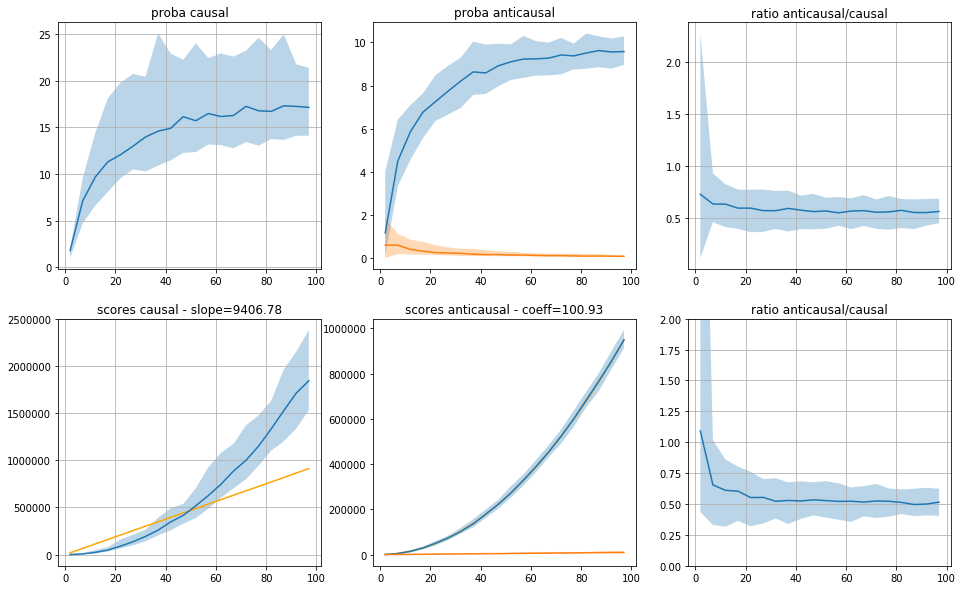

In [450]:
fig, axs = plot6categ(quart1, median, quart3, 'effect')
axs[1,2].set_ylim(0,2)
plt.show()

The expected distance between the current and optimal causal scores grows linearly with the size of the distribution support. For the anticausal scores, it grows quadratically. Both causal and anticausal distances have the same leading coefficient which decreases with the concentration of the Dirichlet distribution.

Actually we can prove that 

$$\|s(A|B) - \tilde s(A|B)\|^2 = K \|s(A) - \tilde s(A)\|^2 $$

which explains the shape of the curve on the right with a negligible influence of the distance $\|s(B) - \tilde s(B)\|^2$.

# Expected distance for Gaussian distributions

In [4]:
import normal_distance

In [401]:
def compute_percentile(dist):
    quart1 = np.percentile(dist,5, axis=1)
    median = np.median(dist, axis=1)
    quart3 = np.percentile(dist,95, axis=1)
    return median, quart1, quart3

In [5]:
def gaussiancausedist(k,n):
    return normal_distance.gaussian_distances(k,n,intervention='cause', symmetric=True)


def gaussianeffectdist(k,n):
    return normal_distance.gaussian_distances(k,n,intervention='effect', symmetric=True)

In [6]:
def plot6(quart1,median,quart3,intervention):
    
    def plotfill(ax,index,label):
        ax.plot(kk,median[:,index], label=label)
        ax.fill_between(kk, quart1[:,index], quart3[:,index], alpha=0.3)
        ax.set_title(label)
        #ax.set_yscale('log')
        ax.grid()

    fig, axs = plt.subplots(2,3, figsize=(16,10))
    plotfill(axs[0,0], 0, 'mean causal')
    plotfill(axs[0, 1], 1, 'mean anticausal')
    plotfill(axs[0,2], 2, 'ratio anticausal/causal')

    plotfill(axs[1, 0], 3, f'natural causal')
    plotfill(axs[1, 1], 4, f'natural anticausal')
    plotfill(axs[1,2], 5, 'ratio anticausal/causal')

    plt.savefig(f'gaussian_distances_intervene_{intervention}.pdf')

In [386]:
intervention='cause'
symmetric=True

gausscausdist = compute_distances(
    lambda k,n: normal_distance.gaussian_distances(k,n,intervention='cause', symmetric=symmetric), n=300)

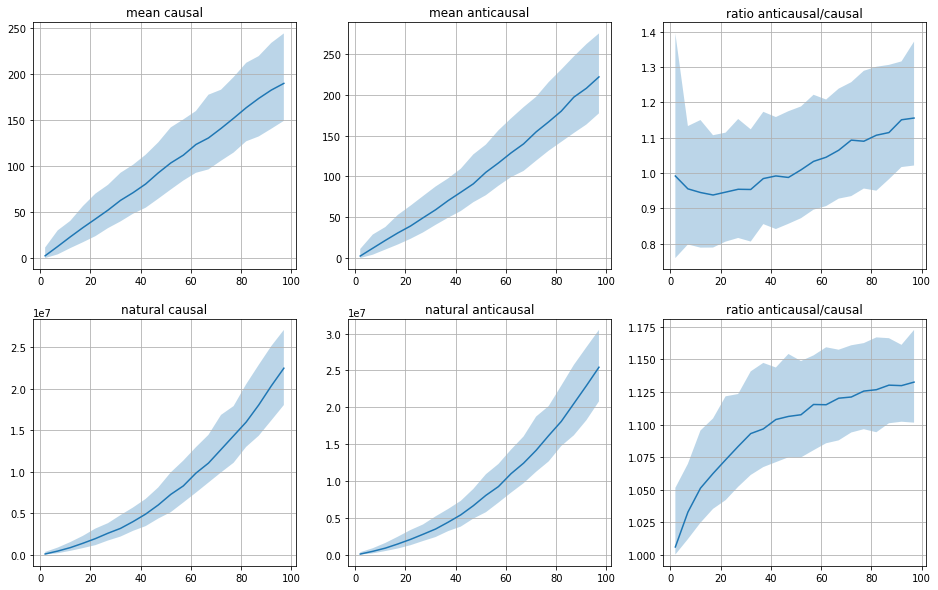

In [387]:
median,quart1,quart3 = compute_percentile(gausscausdist)
plot6(quart1,median,quart3, 'cause_symmetric')

In [388]:
gausseffectdist = compute_distances(gaussianeffectdist, n=300)

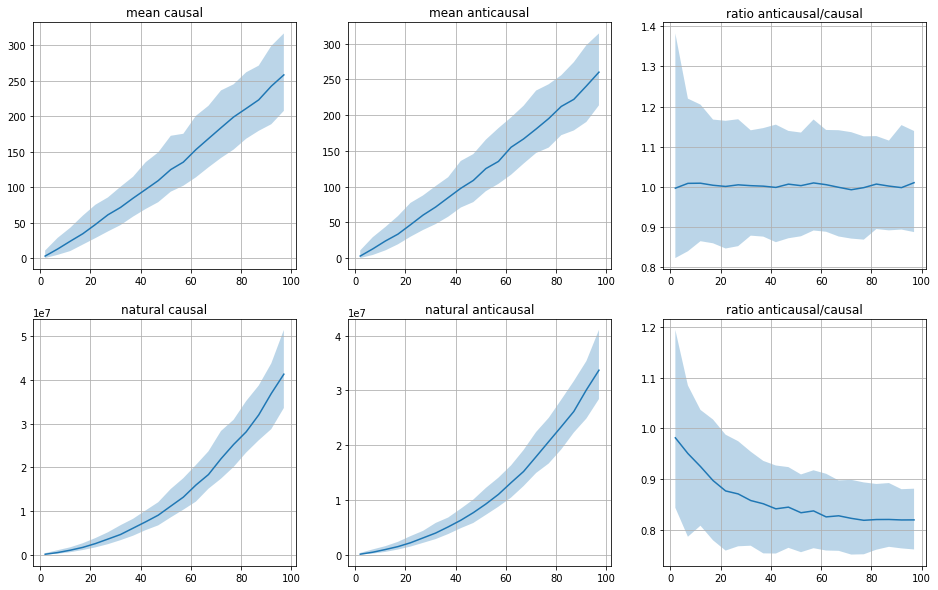

In [389]:
median,quart1,quart3 = compute_percentile(gausseffectdist)
plot6(quart1,median,quart3, 'effect_symmetric')

# Expected distance after a random intervention
This time to avoid insane computations we set the dimension to 20. We measure the effect of random orthonormal transformations on the distance.

In [52]:
dist = normal_distance.transform_distances(k=20,n=100,m=10, intervention='effect')

In [53]:
dsanity = normal_distance.gaussian_distances(k=20,n=100,intervention='effect',symmetric=True)

First simply compare causal and anticausal in scatter plots. Both models are as distant.

Text(0, 0.5, 'anticausal distance, mean parameters')

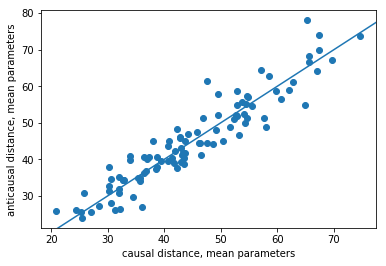

In [54]:
plt.scatter(dist[:,0,0], dist[:,1,0])
plt.plot([0,1000],[0,1000], scalex=False,scaley=False)
plt.xlabel('causal distance, mean parameters')
plt.ylabel('anticausal distance, mean parameters')

Text(0, 0.5, 'anticausal distance, natural parameters')

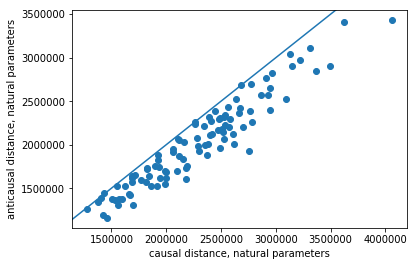

In [55]:
plt.scatter(dist[:,0,1], dist[:,1,1])
#plt.axis('equal')
#plt.ylim(0,1e7)
plt.plot([0,1e20],[0,1e20], scalex=False,scaley=False)
plt.xlabel('causal distance, natural parameters')
plt.ylabel('anticausal distance, natural parameters')

Then compare causal versus everybody else

Text(0, 0.5, 'distance after orthonormal transformation, mean parameters')

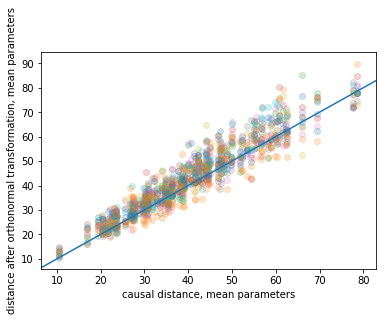

In [42]:
for i in range(dist.shape[1]):
    plt.scatter(dist[:,0,0], dist[:,i,0], alpha=0.2)
    
#plt.ylim(0,1e4)   
#plt.yscale('log')
plt.plot([0,1000],[0,1000], scalex=False,scaley=False)
plt.xlabel('causal distance, mean parameters')
plt.ylabel('distance after orthonormal transformation, mean parameters')

Text(0, 0.5, 'transformed distance, natural parameters')

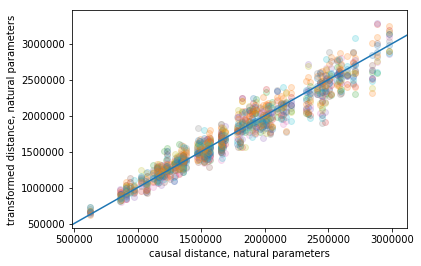

In [43]:
for i in range(dist.shape[1]):
    plt.scatter(dist[:,0,1], dist[:,i,1], alpha=0.2)
    
#plt.yscale('log')    
plt.plot([1,1e20],[1,1e20], scalex=False,scaley=False)
plt.xlabel('causal distance, natural parameters')
plt.ylabel('transformed distance, natural parameters')

Now we experiment with transformations that are increasingly distant from the identity.We observe that there is a clear gradient as the distance grows. It is much more noisy in the natural paremeters, especially when the scale of the perturbation grows larger than 0.2.

In [48]:
xx = np.logspace(-3,0,20)
smalltransforms = normal_distance.transform_distances(k=20,n=100,m=20, transformation='small', noiserange=xx, intervention='cause')

In [49]:
ratio = smalltransforms[:,2:]/smalltransforms[:,0:1]

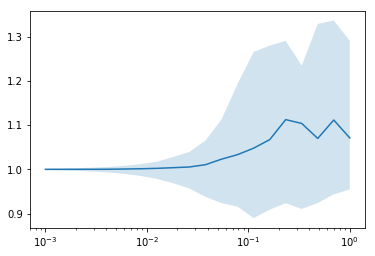

In [50]:
plt.plot(xx, np.median(ratio,axis=0)[:,0])
plt.fill_between(xx,
                np.percentile(ratio,5,axis=0)[:,0],
                np.percentile(ratio,95,axis=0)[:,0],
                alpha=0.2)
plt.xscale('log')

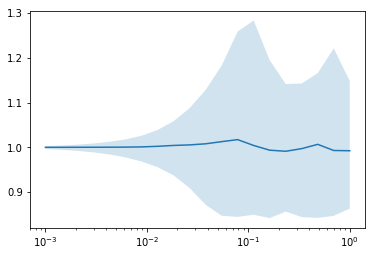

In [51]:
plt.plot(xx,np.median(ratio,axis=0)[:,1])
plt.fill_between(xx,
                 np.percentile(ratio,1,axis=0)[:,1],
                 np.percentile(ratio,99,axis=0)[:,1],
                 alpha=0.2)
plt.xscale('log')